# Translation of Numeric Phrases with Seq2Seq

In the following we will try to build a **translation model from french phrases describing numbers** to the corresponding **numeric representation** (base 10).

This is a toy machine translation task with a **restricted vocabulary** and a **single valid translation for each source phrase** which makes it more tractable to train on a laptop computer and easier to evaluate. Despite those limitations we expect that this task will highlight interesting properties of Seq2Seq models including:

- the ability to **deal with different length** of the source and target sequences,
- handling token with a **meaning that changes depending on the context** (e.g "quatre" in isolation vs "quatre vingts" in "quatre cents"),
- basic counting and "reasoning" capabilities of LSTM and GRU models,
- highlight similar capabilities of transformer-based architectures with positional embedding and causal attention.

The parallel text data is generated from a "ground-truth" Python function named `to_french_phrase` that captures common rules. Hyphenation was intentionally omitted to make the phrases more ambiguous and therefore make the translation problem slightly harder to solve (and also because Olivier had no particular interest in properly implementing hyphenation rules :).

### Objectives

- Learn to build and evaluate **decoder-only sequence to sequence models**;
- Understand auto-regressive training with **Teacher Forcing**;
- Build and train a **transformer architecture from scratch**.

In [1]:
%pip install -q torchinfo torchmetrics seaborn

In [2]:
from urllib.request import urlretrieve
from pathlib import Path


FRENCH_NUMBERS_FILENAME = Path("french_numbers.py")
FRENCH_NUMBERS_URL = (
    "https://raw.githubusercontent.com/ogrisel/dlclass-pytorch/main/"
    f"notebooks/{FRENCH_NUMBERS_FILENAME}"
)
if not FRENCH_NUMBERS_FILENAME.exists():
    urlretrieve(FRENCH_NUMBERS_URL, FRENCH_NUMBERS_FILENAME)

In [3]:
from french_numbers import to_french_phrase

for x in [21, 80, 81, 300, 213, 1100, 1201, 301000, 80080]:
    print(str(x).rjust(6), to_french_phrase(x))

    21 vingt et un
    80 quatre vingts
    81 quatre vingt un
   300 trois cents
   213 deux cent treize
  1100 mille cent
  1201 mille deux cent un
301000 trois cent un mille
 80080 quatre vingt mille quatre vingts


## Generating a Training Set

The following will **generate phrases 20000 example phrases for numbers between 1 and 1,000,000** (excluded). We chose to over-represent small numbers by generating all the possible short sequences between `1` and `exhaustive=5000`.

We then split the generated set into non-overlapping train, validation and test splits.

In [4]:
from french_numbers import generate_translations
from sklearn.model_selection import train_test_split


numbers, french_numbers = generate_translations(
    low=1, high=int(1e6) - 1, exhaustive=5000, random_seed=0
)
num_train, num_dev, fr_train, fr_dev = train_test_split(
    numbers, french_numbers, test_size=0.5, random_state=0
)
num_val, num_test, fr_val, fr_test = train_test_split(
    num_dev, fr_dev, test_size=0.5, random_state=0
)

In [5]:
len(fr_train), len(fr_val), len(fr_test)

(10000, 5000, 5000)

In [6]:
for i, fr_phrase, num_phrase in zip(range(5), fr_train, num_train):
    print(num_phrase.rjust(6), fr_phrase)

  2882 deux mille huit cent quatre vingt deux
372200 trois cent soixante douze mille deux cents
  2193 deux mille cent quatre vingt treize
996418 neuf cent quatre vingt seize mille quatre cent dix huit
  9172 neuf mille cent soixante douze


In [7]:
for i, fr_phrase, num_phrase in zip(range(5), fr_val, num_val):
    print(num_phrase.rjust(6), fr_phrase)

  2804 deux mille huit cent quatre
  3898 trois mille huit cent quatre vingt dix huit
 82996 quatre vingt deux mille neuf cent quatre vingt seize
366346 trois cent soixante six mille trois cent quarante six
 56006 cinquante six mille six


## Vocabularies

Build the vocabularies from the training set only to get a chance to have some out-of-vocabulary words in the validation and test sets.

First we need to introduce specific symbols that will be used to:
- pad sequences
- represent out-of-vocabulary symbols (not seen in the training set)
- mark the beginning of translation
- mark the end of translation.

In [8]:
PAD = "<PAD>"
UNK = "<UNK>"
GO = "<GO>"
EOS = "<EOS>"
START_VOCAB = [PAD, UNK, GO, EOS]

To build the vocabulary we need to tokenize the sequences of symbols. For the digital number representation we use character level tokenization while whitespace-based word level tokenization will do for the French phrases.

To implement such a tokenizer we use the following regular expression:

In [9]:
import re


TOKEN_PATTERN = re.compile(r"(\d|<?[a-zA-ZÀ-ÿ_]+>?)")


def tokenize(sentence):
    """Tokenize any whitespace separated word or any individual digit"""
    return TOKEN_PATTERN.findall(sentence)


In [10]:
tokenize('1234')

['1', '2', '3', '4']

In [11]:
tokenize('mille deux cent trente quatre')

['mille', 'deux', 'cent', 'trente', 'quatre']

Let's also check the behavior of our tokenizer with some edge cases:

In [12]:
tokenize("<UNK>123 45, un 6de_ux<GO>trois!<EOS>")

['<UNK>',
 '1',
 '2',
 '3',
 '4',
 '5',
 'un',
 '6',
 'de_ux',
 '<GO>',
 'trois',
 '<EOS>']

Let's now use this tokenization strategy to assign a unique integer token id to each possible token string found the traing set in each language ('French' and 'numeric'):

In [13]:
def build_vocabulary(tokenized_sequences):
    rev_vocabulary = START_VOCAB[:]
    unique_tokens = set()
    for tokens in tokenized_sequences:
        unique_tokens.update(tokens)
    rev_vocabulary += sorted(unique_tokens)
    vocabulary = {}
    for i, token in enumerate(rev_vocabulary):
        vocabulary[token] = i
    return vocabulary, rev_vocabulary


In [14]:
tokenized_fr_train = [tokenize(s) for s in fr_train]
tokenized_num_train = [tokenize(s) for s in num_train]

vocab, rev_vocab = build_vocabulary(tokenized_fr_train + tokenized_num_train)

The two languages do not have the same vocabulary sizes:

In [15]:
len(vocab)

40

In [16]:
vocab

{'<PAD>': 0,
 '<UNK>': 1,
 '<GO>': 2,
 '<EOS>': 3,
 '0': 4,
 '1': 5,
 '2': 6,
 '3': 7,
 '4': 8,
 '5': 9,
 '6': 10,
 '7': 11,
 '8': 12,
 '9': 13,
 'cent': 14,
 'cents': 15,
 'cinq': 16,
 'cinquante': 17,
 'deux': 18,
 'dix': 19,
 'douze': 20,
 'et': 21,
 'huit': 22,
 'mille': 23,
 'neuf': 24,
 'onze': 25,
 'quarante': 26,
 'quatorze': 27,
 'quatre': 28,
 'quinze': 29,
 'seize': 30,
 'sept': 31,
 'six': 32,
 'soixante': 33,
 'treize': 34,
 'trente': 35,
 'trois': 36,
 'un': 37,
 'vingt': 38,
 'vingts': 39}

We also built the reverse mappings from token ids to token string representations:

In [17]:
rev_vocab

['<PAD>',
 '<UNK>',
 '<GO>',
 '<EOS>',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'cent',
 'cents',
 'cinq',
 'cinquante',
 'deux',
 'dix',
 'douze',
 'et',
 'huit',
 'mille',
 'neuf',
 'onze',
 'quarante',
 'quatorze',
 'quatre',
 'quinze',
 'seize',
 'sept',
 'six',
 'soixante',
 'treize',
 'trente',
 'trois',
 'un',
 'vingt',
 'vingts']

## Seq2Seq with a single GRU architecture

<img src="https://raw.githubusercontent.com/m2dsupsdlclass/lectures-labs/6ccf141172e47a3d9e367620b4d70e1c9564e9d2/labs/07_seq2seq/images/basic_seq2seq.png" width="80%" />

From: [Sutskever, Ilya, Oriol Vinyals, and Quoc V. Le. "Sequence to sequence learning with neural networks." NIPS 2014](https://arxiv.org/abs/1409.3215)



For a given source sequence - target sequence pair, we will:
- tokenize the source and target sequences;
- reverse the order of the source sequence;
- build the input sequence by concatenating the reversed source sequence and the target sequence in original order using the `<GO>` token as a delimiter,
- build the output sequence by appending the `<EOS>` token to the source sequence.


Let's do this as a function using the original string representations for the tokens so as to make it easier to debug:

### Exercise
- Write a function that turns a pair of tokenized sequences (`source`, `target`) into a pair of (`input`, `output`) sequences to be used to train the neural network as represented in the [diagram](https://raw.githubusercontent.com/m2dsupsdlclass/lectures-labs/6ccf141172e47a3d9e367620b4d70e1c9564e9d2/labs/07_seq2seq/images/basic_seq2seq.png) above.
- Expect `source` and `target` to be provided as Python list of string objects and you should also return `input` and `output` as Python list of strings.
- The function should have a `reverse_source=True` as an option to reverse the order of the `source` tokens.

Notes:
- The function should output two sequences of string tokens: one to be fed as the input and the other as expected output for the seq2seq network.
- Do not pad the end of the sequences: we will handle the padding later.
- Don't forget to insert the `<GO>` and `<EOS>` special symbols at the right locations.
- Use `list()` + `reversed()` to reverse the order of the elements of a Python list:
    - `list(reversed(['a', 'b', 'c'])) == ['c', 'b', 'a']`
- To concatenated two Python list, you can use the `+` operator:
    - `['a'] + ['b', 'c'] == ['a', 'b', 'c']`.
- To replicate a symbol n times, it's possible to use the `*` operator:
    - `['a'] * 3 == ['a', 'a', 'a']`

In [18]:
def make_input_output(source_tokens, target_tokens, reverse_source=True):
    # TODO
    input_tokens = []
    output_tokens = []

    # Check that both the generated input and output have the same length
    assert len(input_tokens) == len(output_tokens)

    return input_tokens, output_tokens

In [19]:
input_tokens, output_tokens = make_input_output(
    ['cent', 'vingt', 'et', 'un'],
    ['1', '2', '1'],
    reverse_source=True,
)
# Expected pair of returned sequences:
# input =  ['un',    'et',    'vingt', 'cent',  '<GO>',  '1',    '2',    '1']
# output = ['<PAD>', '<PAD>', '<PAD>', '<PAD>', '1',     '2',    '1',    '<EOS>']

### Solution

In [20]:
def make_input_output(source_tokens, target_tokens, reverse_source=True):
    if reverse_source:
        source_tokens = list(reversed(source_tokens))

    input_tokens = source_tokens + [GO] + target_tokens
    output_tokens = ([PAD] * len(source_tokens)) + target_tokens + [EOS]

    # Check that both the generated input and output have the same length
    assert len(input_tokens) == len(output_tokens)

    return input_tokens, output_tokens

In [21]:
input_tokens, output_tokens = make_input_output(
    ['cent', 'vingt', 'et', 'un'],
    ['1', '2', '1'],
)

In [22]:
input_tokens

['un', 'et', 'vingt', 'cent', '<GO>', '1', '2', '1']

In [23]:
output_tokens

['<PAD>', '<PAD>', '<PAD>', '<PAD>', '1', '2', '1', '<EOS>']

### Vectorization of the parallel corpus

Let's apply the previous transformation to each pair of (source, target) sequence to store the results in numpy arrays of integer token ids, with padding on the left so that all input / output sequences have the same length:

In [24]:
max(len(s) for s in tokenized_fr_train)

13

In [25]:
max(len(s) for s in tokenized_num_train)

6

In [26]:
import numpy as np


def vectorize_corpus(
    source_sequences,
    target_sequences,
    shared_vocab,
    max_length=20,  # found by introspection of our training set
    reverse_source=True,
):
    assert len(source_sequences) == len(target_sequences)
    n_sequences = len(source_sequences)
    source_ids = np.full(
        fill_value=shared_vocab[PAD],
        shape=(n_sequences, max_length),
        dtype=np.int64,
    )
    target_ids = source_ids.copy()
    numbered_pairs = zip(range(n_sequences), source_sequences, target_sequences)
    for i, source_seq, target_seq in numbered_pairs:
        source_tokens = tokenize(source_seq)
        target_tokens = tokenize(target_seq)

        in_tokens, out_tokens = make_input_output(
            source_tokens, target_tokens, reverse_source=reverse_source
        )

        in_token_ids = [shared_vocab.get(t, shared_vocab[UNK]) for t in in_tokens]
        source_ids[i, : len(in_tokens)] = in_token_ids

        out_token_ids = [shared_vocab.get(t, shared_vocab[UNK]) for t in out_tokens]
        target_ids[i, : len(out_tokens)] = out_token_ids

    return source_ids, target_ids


In [27]:
X_train, Y_train = vectorize_corpus(fr_train, num_train, vocab)

In [28]:
X_train.shape

(10000, 20)

In [29]:
X_train[0]

array([18, 38, 28, 14, 22, 23, 18,  2,  6, 12, 12,  6,  0,  0,  0,  0,  0,
        0,  0,  0])

In [30]:
Y_train[0]

array([ 0,  0,  0,  0,  0,  0,  0,  6, 12, 12,  6,  3,  0,  0,  0,  0,  0,
        0,  0,  0])

In [31]:
fr_train[0]

'deux mille huit cent quatre vingt deux'

In [32]:
num_train[0]

'2882'

In [33]:
X_train[0]

array([18, 38, 28, 14, 22, 23, 18,  2,  6, 12, 12,  6,  0,  0,  0,  0,  0,
        0,  0,  0])

In [34]:
Y_train[0]

array([ 0,  0,  0,  0,  0,  0,  0,  6, 12, 12,  6,  3,  0,  0,  0,  0,  0,
        0,  0,  0])

This looks good. In particular we can note:

- the `<PAD> = 0` symbol at the end of the two sequences,
- the input sequence has the `<GO> = 2` symbol to separate the source from the target,
- the output sequence is a shifted version of the target and ends with `<EOS> = 3`.

Let's vectorize the validation and test set to be able to evaluate our models:

In [35]:
X_val, Y_val = vectorize_corpus(fr_val, num_val, vocab)
X_test, Y_test = vectorize_corpus(fr_test, num_test, vocab)

In [36]:
X_val.shape, Y_val.shape

((5000, 20), (5000, 20))

In [37]:
X_test.shape, Y_test.shape

((5000, 20), (5000, 20))

In [38]:
import torch
from torch.utils.data import DataLoader, TensorDataset


DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

In [39]:
train_dl = DataLoader(
    TensorDataset(
        torch.from_numpy(X_train).to(DEVICE),
        torch.from_numpy(Y_train).to(DEVICE),
    ),
    batch_size=64,
    shuffle=True,
)

validation_dl = DataLoader(
    TensorDataset(
        torch.from_numpy(X_val).to(DEVICE),
        torch.from_numpy(Y_val).to(DEVICE),
    ),
    batch_size=512,
)

test_dl = DataLoader(
    TensorDataset(
        torch.from_numpy(X_test).to(DEVICE),
        torch.from_numpy(Y_test).to(DEVICE),
    ),
    batch_size=512,
)

In [40]:
first_input_batch, first_output_batch = next(iter(train_dl))
first_input_batch.shape, first_input_batch.dtype

(torch.Size([64, 20]), torch.int64)

In [41]:
first_input_batch[0]

tensor([31, 35, 14, 31, 23, 28,  2,  8, 11,  7, 11,  0,  0,  0,  0,  0,  0,  0,
         0,  0], device='cuda:0')

In [42]:
first_output_batch.shape, first_output_batch.dtype

(torch.Size([64, 20]), torch.int64)

In [43]:
first_output_batch[0]

tensor([ 0,  0,  0,  0,  0,  0,  8, 11,  7, 11,  3,  0,  0,  0,  0,  0,  0,  0,
         0,  0], device='cuda:0')

### A simple homogeneous Seq2Seq architecture

To keep the architecture simple we will use a **decoder-only** architecture that will use a single RNN model fed with both the source tokens (before the `<GO>` token) and the target tokens (after the `<GO>` token) and we will use teacher-forcing to train this end-to-end.

We may GRU recurrent cell instead of LSTM because it is slightly faster to compute and should give comparable results.

before building the model, we will simulate a forward pass step by step to introduce the different layers and shape of their outputs.

Let's start with the embedding layer:

In [44]:
embedding_dim = 64

embedding_layer = torch.nn.Embedding(
    num_embeddings=len(vocab),
    embedding_dim=embedding_dim,
).to(DEVICE)
embedded_batch = embedding_layer(first_input_batch)
embedded_batch.shape
# (batch_size, sequence_length, embedding_dim)

torch.Size([64, 20, 64])

In [45]:
embedded_batch.dtype

torch.float32

Then we feed the sequence of embedded token vectors to a recurrent layer. This layer return both per-time step hidden states and the hidden state of the final step:

In [46]:
gru_hidden_dim = 256

gru_layer = torch.nn.GRU(
    input_size=embedding_dim,
    hidden_size=gru_hidden_dim,
    num_layers=2,
    batch_first=True
).to(DEVICE)
gru_last_layer_per_step_output, gru_per_layer_final_step_output = gru_layer(embedded_batch)

In [47]:
gru_last_layer_per_step_output.shape
# (batch_size, sequence_length, gru_hidden_dim)

torch.Size([64, 20, 256])

In [48]:
gru_per_layer_final_step_output.shape
# (num_gru_layers, batch_size, gru_hidden_dim)

torch.Size([2, 64, 256])

We do not need `gru_per_layer_final_step_output` for our use case. Instead we want to map the ouput of the last layer to a class logit (unormalized probability) at each step in the sequence.

To do this we can either use a `torch.nn.Linear()` layer that maps from the `gru_hidden_dim` space to the `len(vocab)` logit space. If the `gru_hidden_dim` axis is presented in the last postition to the `Linear` layer, the linear operation will automatically be applied independently at each step in the sequence:

In [49]:
gru_last_layer_per_step_output.shape

torch.Size([64, 20, 256])

In [50]:
linear_classifier_layer = torch.nn.Linear(
    in_features=gru_hidden_dim,
    out_features=len(vocab),
).to(DEVICE)
linear_classifier_output = linear_classifier_layer(gru_last_layer_per_step_output)
linear_classifier_output.shape
# (batch_size, sequence_length, len(vocab))

torch.Size([64, 20, 40])

Alternatively, it would have been possible to use a `torch.nn.Conv1d` operation to obtain a similar result. However it needs being fed it's input swapped `gru_hidden_dim` and `sequence_length` axis:

In [51]:
gru_last_layer_per_step_output.shape
# (batch_size, sequence_length, gru_hidden_dim)

torch.Size([64, 20, 256])

In [52]:
gru_last_layer_per_step_output.transpose(1, 2).shape
# (batch_size, gru_hidden_dim, sequence_length)

torch.Size([64, 256, 20])

In [53]:
conv1d_classifier_layer = torch.nn.Conv1d(
    in_channels=gru_hidden_dim,
    out_channels=len(vocab),
    kernel_size=1,
).to(DEVICE)
conv1d_classifier_output = conv1d_classifier_layer(gru_last_layer_per_step_output.transpose(1, 2))
conv1d_classifier_output.shape
# (batch_size, len(vocab), sequence_length)

torch.Size([64, 40, 20])

Depending on how we will use the final output of the classifier, we might want to decide to swap the ` len(vocab)` and `sequence_length` axis again with another call to `.transpose(1, 2)` if needed.

Since we will use the `torch.nn.CrossEntropyLoss` criterion to optimize the full architecture end-to-end, we, need to ensure that per-token predictions are shaped `(batch, vocab_size, sequence_length)`:

In [54]:
linear_classifier_output.transpose(1, 2).shape

torch.Size([64, 40, 20])

In [55]:
first_output_batch.shape

torch.Size([64, 20])

In [56]:
xe_loss = torch.nn.CrossEntropyLoss()

xe_loss(
    linear_classifier_output.transpose(1, 2),
    first_output_batch,
)

tensor(3.7337, device='cuda:0', grad_fn=<NllLoss2DBackward0>)

In [57]:
conv1d_classifier_output.shape

torch.Size([64, 40, 20])

In [58]:
xe_loss(conv1d_classifier_output, first_output_batch)

tensor(3.6930, device='cuda:0', grad_fn=<NllLoss2DBackward0>)



#### Exercise

- Build a Seq2Seq module by wrapping all the previous steps into a Pytorch class:
  - Start with an `nn.Embedding` layer;
  - Add a single-layer `nn.GRU` module: the GRU layer should yield a sequence of output vectors, one at each timestep;
  - Add a per-token linear classifier, either using a `nn.Conv1d` layer with a kernel size of `1` or a `nn.Linear` layer as explained previously;
  - Your model should output a shape `(batch, vocab_size, sequence_length)`. This will be needed later so that the cross-entropy loss of pytorch can work on a sequencial classification problem where the global, sequence-level loss is computed as the sum of the token-level classification loss.

Note:
- The output dimension of the `nn.Embedding` layer should be smaller than usual be cause we have small vocabulary size;
- The dimension of the GRU representation is typically chosen to be larger than the dimension of its input tokens to give the Seq2Seq model enough "working memory" to memorize the full source sequence before decoding the first token of target sequence (when processing the `<GO>` token);
- You may want to insert `assert x.shape == (batch_size, expected_dim_1, expected_dim_2)` at each step of the forward pass to make it easier to debug what's going on when designing your model.

In [59]:
import torch.nn as nn


class RecurrentSeq2Seq(nn.Module):

    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int) -> None:
        super(RecurrentSeq2Seq, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # TODO: define layers for embedding the sequence tokens (using nn.Embedding),
        # predict the next token hidden state from the previous tokens using a recurrent
        # layer such as nn.GRU or nn.LSTM, and finally mapping those hidden states
        # to valid classifications amonve vocab_size possible classes (for instance using
        # a nn.Conv1d or nn.Linear layer).

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len = input.shape

        # TODO: write me instead of returning the input!
        return input


recurrent_seq2seq = RecurrentSeq2Seq(vocab_size=len(vocab), embedding_dim=64, hidden_dim=256).to(DEVICE)

with torch.no_grad():
    y_pred = recurrent_seq2seq(first_input_batch)

y_pred.shape

torch.Size([64, 20])

#### Question

- Which layers in your models hold trainable parameters?

- Which layer have the largest number of parameters? It's ok if you don't know how to compute the number of parameters of the GRU layer(s), feel free to use PyTorch instead.


#### Solution

In [60]:
import torch.nn as nn


class RecurrentSeq2Seq(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super(RecurrentSeq2Seq, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,  # num_layers=2 makes the model work better but slower
            dropout=0 if num_layers == 1 else dropout,  # only used when num_layers >= 2
            batch_first=True,  # to follow the usual shape convention
        )

        # Vocab size as output dim for we want to predict the next token. Note
        # that we could also
        self.token_classifier = nn.Conv1d(
            in_channels=hidden_dim,
            out_channels=vocab_size,
            kernel_size=1,
        )

    def forward(self, input):
        batch_size, seq_len = input.shape
        embedded_seq = self.embedding(input)
        assert embedded_seq.shape == (batch_size, seq_len, self.embedding_dim)

        embedded_seq = self.dropout(embedded_seq)

        gru_seq, _ = self.gru(embedded_seq)
        assert gru_seq.shape == (batch_size, seq_len, self.hidden_dim)

        # We need to transpose the sequence to be able to use the Conv1d layer.
        gru_seq = gru_seq.transpose(1, 2)
        assert gru_seq.shape == (batch_size, self.hidden_dim, seq_len)

        logits_seq = self.token_classifier(gru_seq)
        assert logits_seq.shape == (batch_size, self.vocab_size, seq_len)

        return logits_seq


recurrent_seq2seq = RecurrentSeq2Seq(
    vocab_size=len(vocab), embedding_dim=64, hidden_dim=256
).to(DEVICE)

with torch.no_grad():
    y_pred = recurrent_seq2seq(first_input_batch)

y_pred.shape


torch.Size([64, 40, 20])

In [61]:
first_output_batch.shape

torch.Size([64, 20])

In [62]:
torch.nn.functional.cross_entropy(y_pred, first_output_batch)

tensor(3.5860, device='cuda:0')

Let's have a look a the trainable parameters:

In [63]:
from torchinfo import summary

summary(recurrent_seq2seq, input_data=first_input_batch)

Layer (type:depth-idx)                   Output Shape              Param #
RecurrentSeq2Seq                         [64, 40, 20]              --
├─Embedding: 1-1                         [64, 20, 64]              2,560
├─Dropout: 1-2                           [64, 20, 64]              --
├─GRU: 1-3                               [64, 20, 256]             247,296
├─Conv1d: 1-4                            [64, 40, 20]              10,280
Total params: 260,136
Trainable params: 260,136
Non-trainable params: 0
Total mult-adds (M): 329.86
Input size (MB): 0.01
Forward/backward pass size (MB): 3.69
Params size (MB): 1.04
Estimated Total Size (MB): 4.74

Size of the embedding matrix:

In [64]:
len(vocab) * embedding_dim

2560

The GRU cell is reachly parametrized with parameters packed into 2 matrices and 2 vectors of biases. Please refer to the Pytorch source code for more details.

In [65]:
for p in recurrent_seq2seq.gru.parameters():
    print(p.shape)

torch.Size([768, 64])
torch.Size([768, 256])
torch.Size([768])
torch.Size([768])


The output classification layer is bigger than the embedding layer because of the larger `gru_hidden_dim`:

In [66]:
gru_hidden_dim * len(vocab) + len(vocab)

10280


#### Exercise

- Write a function that implements a training loop:
  - use the cross-entropy as the classification loss;
  - use Adam as the optimizer (with the provided parameters below);
  - report the training loss at the end of each epoch;
  - compute the token level accuracy on a validation set a each iteration (you can use the torchmetrics helpers if you like);
  - consume the training data by iterating over the prepared data loader objects: `train_dl` and `validation_dl`.

- Test your code by running it for 10 epochs.

In [67]:
from torchmetrics import Accuracy


optimizer = torch.optim.Adam(
    params=recurrent_seq2seq.parameters(), lr=5e-3, weight_decay=1e-6
)
criterion = torch.nn.CrossEntropyLoss()


def train_model(
    model,
    optimizer,
    criterion,
    train_dl,
    validation_dl,
    num_epochs=10,
    num_classes=len(vocab),
):
    pass  # TODO: implement me!

## Solution:

In [68]:
def train_model(
    model,
    optimizer,
    criterion,
    train_dl,
    validation_dl,
    num_epochs=10,
    num_classes=len(vocab),
):
    val_acc = Accuracy(task="multiclass", top_k=1, num_classes=num_classes).to(DEVICE)
    train_acc = Accuracy(task="multiclass", top_k=1, num_classes=num_classes).to(DEVICE)

    for epoch in range(num_epochs):
        train_losses = []
        model.train()
        for input_ids_batch, label_ids_batch in train_dl:

            preds = model(input_ids_batch)

            loss = criterion(preds, label_ids_batch)
            train_losses.append(loss.item())
            train_acc.update(preds, label_ids_batch)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_train_acc = train_acc.compute()
        train_acc.reset()

        val_losses = []
        model.eval()
        with torch.no_grad():
            for input_ids_batch, label_ids_batch in validation_dl:
                preds = model(input_ids_batch)
                val_acc.update(preds, label_ids_batch)
                val_losses.append(criterion(preds, label_ids_batch).item())

            epoch_val_acc = val_acc.compute()
            val_acc.reset()

        print(
            f"Epoch {epoch}, "
            f"Train loss: {np.mean(train_losses):.4f}, "
            f"Val loss: {np.mean(val_losses):.4f}, "
            f"Val acc: {epoch_val_acc.item():.2f}, "
            f"Train acc: {epoch_train_acc.item():.2f}"
        )


train_model(recurrent_seq2seq, optimizer, criterion, train_dl, validation_dl)

Epoch 0, Train loss: 0.4397, Val loss: 0.1392, Val acc: 0.95, Train acc: 0.87
Epoch 1, Train loss: 0.0772, Val loss: 0.0277, Val acc: 0.99, Train acc: 0.98
Epoch 2, Train loss: 0.0218, Val loss: 0.0084, Val acc: 1.00, Train acc: 0.99
Epoch 3, Train loss: 0.0089, Val loss: 0.0042, Val acc: 1.00, Train acc: 1.00
Epoch 4, Train loss: 0.0040, Val loss: 0.0027, Val acc: 1.00, Train acc: 1.00
Epoch 5, Train loss: 0.0024, Val loss: 0.0018, Val acc: 1.00, Train acc: 1.00
Epoch 6, Train loss: 0.0014, Val loss: 0.0010, Val acc: 1.00, Train acc: 1.00
Epoch 7, Train loss: 0.0009, Val loss: 0.0010, Val acc: 1.00, Train acc: 1.00
Epoch 8, Train loss: 0.0061, Val loss: 0.0355, Val acc: 0.99, Train acc: 1.00
Epoch 9, Train loss: 0.0112, Val loss: 0.0018, Val acc: 1.00, Train acc: 1.00


Let's have a look at a raw prediction on the first sample of the test set:

In [69]:
fr_test[0]

'quatre vingt seize mille deux cent trente sept'

In numeric array this is provided (along with the expected target sequence) as the following padded input sequence:

In [70]:
first_test_sequence = torch.from_numpy(X_test[0]).to(DEVICE)
first_test_sequence

tensor([31, 35, 14, 18, 23, 30, 38, 28,  2, 13, 10,  6,  7, 11,  0,  0,  0,  0,
         0,  0], device='cuda:0')

Remember that the `<GO>` (symbol indexed at `2`) separates the reversed source from the expected target sequence:  

In [71]:
rev_vocab[2]

'<GO>'

### Interpreting the model prediction

**Exercise**:
- Feed this test sequence into the model. What is the shape of the output?
- Get the argmax of each output prediction to get the most likely symbols
- Dismiss the padding / end of sentence
- Convert to readable vocabulary using `rev_vocab`

*Interpretation*
- Compare the output with the first example in numerical format `num_test[0]`
- What do you think of this way of decoding? Is it correct to use it at inference time?

In [72]:
# TODO: write your code here

#### Solution

In [73]:
with torch.no_grad():
    fist_test_preds = recurrent_seq2seq(first_test_sequence.unsqueeze(0)).squeeze()
fist_test_preds.shape

torch.Size([40, 20])

In [74]:
most_likely_class_indices = fist_test_preds.argmax(dim=0)
most_likely_class_indices

tensor([ 0,  0,  0,  0,  0,  0,  0,  0, 13, 10,  6,  7, 11,  3,  0,  0,  0,  0,
         0,  0], device='cuda:0')

In [75]:
for i in most_likely_class_indices.cpu().numpy():
    if i in (vocab[PAD],vocab[EOS]):
        continue
    print(rev_vocab[i], end="")

96237

In [76]:
fr_test[0]

'quatre vingt seize mille deux cent trente sept'

In the previous exercise we cheated because we gave the complete sequence along with the solution in the input sequence instead of the previously predicted tokens of the same sequence.

To be more realistic we need to use the model in a setting where we do not provide any token of expected translation as part of the input sequence: the model shall predict one token at a time starting only from the source sequence along with the `<GO>` special symbol. At each step, we append the new predicted output token in the input sequence to predict the next token:

In [77]:
def greedy_translate(
    model,
    source_sequence,
    vocab,
    rev_vocab,
    max_length=20,
    target_separator="",
):
    """Greedy decoder recursively predicting one token at a time"""
    # Initialize the list of input token ids with the source sequence
    source_tokens = tokenize(source_sequence)
    input_ids = [vocab.get(t, vocab[UNK]) for t in reversed(source_tokens)]
    input_ids += [vocab[GO]]

    # Prepare a fixed size numpy array that matches the expected input
    # shape for the model
    input_array = np.empty(shape=(1, max_length), dtype=np.int64)
    decoded_tokens = []
    while len(input_ids) <= max_length:
        # Vectorize a the list of input tokens as
        # and use zeros padding.
        input_array.fill(vocab[PAD])
        input_array[0, :len(input_ids)] = input_ids

        # Predict the next output: greedy decoding with argmax
        with torch.no_grad():
            logits = model(torch.from_numpy(input_array).to(DEVICE)).cpu().numpy()
            next_token_idx = len(input_ids) - 1
            next_token_id = logits[0, :, next_token_idx].argmax()

        # Stop decoding if the network predicts end of sentence:
        if next_token_id == vocab[EOS]:
            break

        # Otherwise use the reverse vocabulary to map the prediction
        # back to the string space
        decoded_tokens.append(rev_vocab[next_token_id])

        # Append prediction to input sequence to predict the next
        input_ids.append(next_token_id)

    return target_separator.join(decoded_tokens)


In [78]:
phrases = [
    "un",
    "deux",
    "trois",
    "onze",
    "quinze",
    "cent trente deux",
    "deux cent mille douze",
    "sept mille huit cent cinquante neuf",
    "vingt et un",
    "vingt quatre",
    "quatre vingts",
    "quatre vingt onze mille",
    "quatre vingt onze mille deux cent deux",
]
for phrase in phrases:
    translation = greedy_translate(recurrent_seq2seq, phrase, vocab, rev_vocab)
    print(phrase.ljust(40), translation)


un                                       1
deux                                     2
trois                                    30
onze                                     11
quinze                                   15
cent trente deux                         132
deux cent mille douze                    200012
sept mille huit cent cinquante neuf      7859
vingt et un                              21
vingt quatre                             24
quatre vingts                            480
quatre vingt onze mille                  91000
quatre vingt onze mille deux cent deux   91202


Let's have a look at generalization out of correct French and see if the network would generalize like a French speaker would do:

In [79]:
phrases = [
    "quatre vingt et un",
    "quarante douze",
    "soixante vingt sept",
    "cent soixante vingt quatorze",
    "123",
]
for phrase in phrases:
    translation = greedy_translate(recurrent_seq2seq, phrase, vocab, rev_vocab)
    print(phrase.ljust(40), translation)


quatre vingt et un                       81
quarante douze                           42
soixante vingt sept                      787
cent soixante vingt quatorze             174
123                                      


## Model evaluation

Because **we expect only one correct translation** for a given source sequence, we can use **phrase-level accuracy** as a metric to quantify our model quality.

Note that **this is not the case for real translation models** (e.g. from French to English on arbitrary sentences). Evaluation of a machine translation model is tricky in general. Automated evaluation can somehow be done at the corpus level with the [BLEU score](https://en.wikipedia.org/wiki/BLEU) (bilingual evaluation understudy) given a large enough sample of correct translations provided by certified translators but its only a noisy proxy.

The only good evaluation is to give a large enough sample of the model predictions on some test sentences to certified translators and ask them to give an evaluation (e.g. a score between 0 and 6, 0 for non-sensical and 6 for the hypothetical perfect translation). However in practice this is very costly to do.

Fortunately we can just use phrase-level accuracy on a our very domain specific toy problem:

In [80]:
def phrase_accuracy(
    model,
    num_sequences,
    fr_sequences,
    n_samples=300,
    decoder_func=greedy_translate,
    verbose_pass=False,
    verbose_fail=True,
):
    correct = []
    n_samples = len(num_sequences) if n_samples is None else n_samples
    for _, num_seq, fr_seq in zip(range(n_samples), num_sequences, fr_sequences):
        predicted_seq = decoder_func(model, fr_seq, vocab, rev_vocab)
        correct.append(num_seq == predicted_seq)
        if verbose_pass and num_seq == predicted_seq:
            print(f"✅ PASS: {fr_seq} => {predicted_seq}")
        if verbose_fail and num_seq != predicted_seq:
            print(f"❌ FAIL: {fr_seq} => {predicted_seq}")
    return np.mean(correct)


In [81]:
train_acc = phrase_accuracy(recurrent_seq2seq, num_train, fr_train)
print(f"Phrase-level train accuracy: {train_acc:.03f}")

❌ FAIL: deux cent seize mille six cent soixante dix sept => 116677
Phrase-level train accuracy: 0.997


In [82]:
test_acc = phrase_accuracy(recurrent_seq2seq, num_test, fr_test)
print(f"Phrase-level test accuracy: {test_acc:.03f}")

❌ FAIL: cent trente trois mille six cent soixante neuf => 133699
❌ FAIL: trois => 30
Phrase-level test accuracy: 0.993


### GPT-style transformers from scratch

Nowadays, transformer-based architectures have been very successful at auto-regressive sequential tasks, notably for natural language processing tasks where they often out-perform recurrent networks.

In the following we will implement a [GPT](https://www.semanticscholar.org/paper/Improving-Language-Understanding-by-Generative-Radford-Narasimhan/cd18800a0fe0b668a1cc19f2ec95b5003d0a5035) style network from scratch by progressively assembling building blocks adapted from [minGPT](https://github.com/karpathy/minGPT) (more precisely the `gpt-micro` variant).

Here are the main architecutural considerations to keep in mind:

- The GPT architecture is a transformer architecture, that is stack of self-attensional modules.
- The sequential structure is not built-in in the transformer architecture which is permutation invariant by default. The sequetial information is included via the addition to input embedding of positional embeddings;
- When training transformer on auto-regressive tasks with a teacher-forcing strategy, it is important to further enforce **causal** constraints to transform the embedding of given token only from information derived from the previous tokens in the input sequencel. In transformers, causal constraints are typically included by masking the attention weights to give a weight of 0 (after the softmax) or -inf (before the softmax) to tokens that appear later in the sequence.

The general architecture is has follows (inputs first):

- Convert input token with an `Embedding` layer;
- Add position embedding to each token vector;
- Repeat transformation with the following residual block `num_blocks`-times:
    - Transform tokens via multi-head self-attention
    - LayerNorm
    - Apply MLP with tied weights to
    - LayerNorm
- Apply a final classification head to map from the transformer `embedding_dim`
  output classification logits to each sequence token (taking into account the
  vocabulary size).

<img src="https://www.researchgate.net/publication/349521999/figure/fig1/AS:994338746146817@1614080239754/Decoder-Only-Architecture-used-by-GPT-2.ppm"
  height="300px"
/>

Let's start with the definition of a self-attentional module:

In [83]:
import torch.nn.functional as F
import math


class CausalSelfAttention(nn.Module):
    """The main module of the Transformer model.

    A vanilla multi-head masked self-attention layer with a linear projection
    at the end that reuses the naming convention of our notebook.

    A similar module is available as torch.nn.MultiheadAttention.
    """

    def __init__(
        self,
        sequence_length,
        embedding_dim=768,
        num_heads=12,
        dropout=0.1,
    ):
        super().__init__()
        self.sequence_length = sequence_length
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim

        # Make sure that the hidden embedding dimension is divisible by the
        # number of heads.
        assert embedding_dim % num_heads == 0

        # key, query, value linear projections for all heads, but all packed
        # into a single matrix for efficiency.
        self.csa_attn = nn.Linear(embedding_dim, 3 * embedding_dim)

        # Output projection.
        self.csa_proj = nn.Linear(embedding_dim, embedding_dim)

        # stochastic regularization.
        self.attn_dropout = nn.Dropout(dropout)
        self.proj_dropout = nn.Dropout(dropout)

        # Causal attention mask to ensure that attention is only applied to the
        # left in the input sequence.
        causal_mask = torch.tril(torch.ones(sequence_length, sequence_length)).view(
            1, 1, sequence_length, sequence_length
        )
        self.register_buffer("causal_mask", causal_mask)

    def forward(self, x):
        (
            batch_size,
            sequence_length,
            embedding_dim,
        ) = x.size()  # batch size, sequence length, embedding dimensionality
        assert embedding_dim == self.embedding_dim
        assert sequence_length == self.sequence_length
        head_dim = embedding_dim // self.num_heads

        # calculate query, key, values for all heads in batch and move head
        # forward to be the batch dim
        q, k, v = self.csa_attn(x).split(embedding_dim, dim=2)
        k = k.view(batch_size, sequence_length, self.num_heads, head_dim).transpose(
            1, 2
        )  # (batch_size, num_heads, sequence_length, head_dim)
        q = q.view(batch_size, sequence_length, self.num_heads, head_dim).transpose(
            1, 2
        )  # (batch_size, num_heads, sequence_length, head_dim)
        v = v.view(batch_size, sequence_length, self.num_heads, head_dim).transpose(
            1, 2
        )  # (batch_size, num_heads, sequence_length, head_dim)

        # Self-attention:
        # (batch_size, num_heads, sequence_length, head_dim)
        # x (batch_size, num_heads, head_dim, sequence_length)
        # -> (batch_size, num_heads, sequence_length, sequence_length)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))

        # Apply the causal mask to attention so that the model cannot "cheat":
        att = att.masked_fill(self.causal_mask == 0, float("-inf"))

        # Normalize the attention weights to positive values that sum to 1.0.
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)

        # Aggregegate the value vectors using the attention weights:
        # (batch_size, num_heads, sequence_length, sequence_length)
        # x (batch_size, num_heads, sequence_length, head_dim)
        # -> (batch_size, num_heads, sequence_length, head_dim)
        y = att @ v

        # Re-assemble all head outputs side by side:
        y = (
            y.transpose(1, 2).contiguous().view(batch_size, sequence_length, embedding_dim)
        )

        # Output projection:
        y = self.proj_dropout(self.csa_proj(y))

        # Return both the final output and the attention weights to make it
        # possible to gain some insights about the inner workings of the model.
        return y, att


Let's build a randomly initiliazed instance of `CausalSelfAttention` with 4 heads to be used on a sequence of 10 random token vectors (in a batch of 1):

In [84]:
causal_self_attention = CausalSelfAttention(
    num_heads=4,
    sequence_length=10,
    embedding_dim=256,
)

with torch.no_grad():
    test_tokens = torch.randn(1, 10, 256)
    test_output, test_att = causal_self_attention(test_tokens)

In [85]:
test_output.shape

torch.Size([1, 10, 256])

In [86]:
test_att.shape

torch.Size([1, 4, 10, 10])

Let's visualize the attention maps of the 4 self-attention heads:

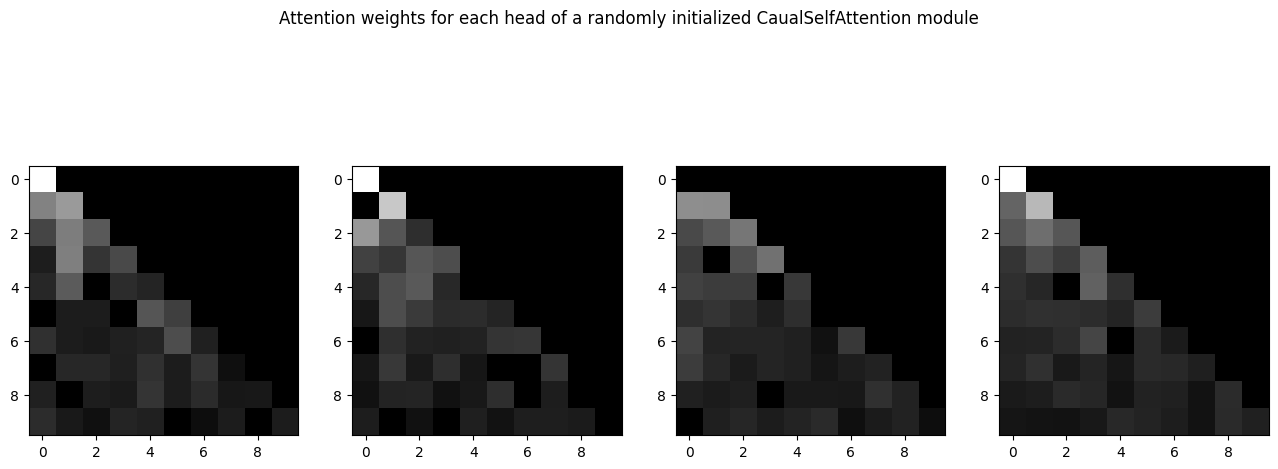

In [87]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=causal_self_attention.num_heads, figsize=(16, 6))
for head_idx in range(causal_self_attention.num_heads):
    ax[head_idx].imshow(test_att[0, head_idx].numpy(), cmap="gray", vmin=0, vmax=1)
_ = plt.suptitle("Attention weights for each head of a randomly initialized CaualSelfAttention module")

One can observe that to compute the new embedding for the token at position `0`, all the weight is concentrated to the previous embedding of token `0` while for token at position `9`, the attentions weights are randomly (uniformly) spread onto the all the tokens of the sequence, hence the name "causal attention".

We will later see how those attention maps typically look for particular predicted tokens on a trained transformer model.

The MLP modules in transformers typically use the GELU activation function place of the traditional ReLU activation function. Here is the definition of this function:

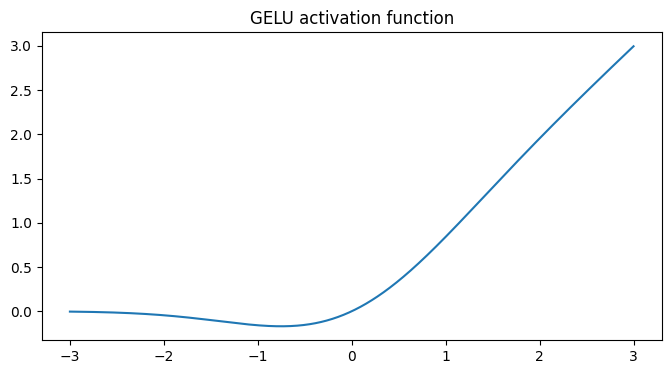

In [88]:
import math

x = torch.linspace(-3, 3, 1000)
gelu = torch.nn.GELU()

plt.figure(figsize=(8, 4))
plt.plot(x, gelu(x).detach().numpy())
_ = plt.title("GELU activation function")


We can now define the main transformer block by assembling a self-attentional module, followed by a token-wise MLP module:

In [89]:
class TransformerBlock(nn.Module):
    def __init__(self, sequence_length, embedding_dim=768, num_heads=12, dropout=0.1):
        super().__init__()

        self.ln_1 = nn.LayerNorm(embedding_dim)
        self.self_attn = CausalSelfAttention(
            sequence_length,
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            dropout=dropout,
        )

        self.ln_2 = nn.LayerNorm(embedding_dim)

        # MLP with a GELU activation function and dropout. The hidden layer has
        # 4 times the dimensionality of its input.
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim, 4 * embedding_dim),
            nn.GELU(),
            nn.Linear(4 * embedding_dim, embedding_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        xa, attn_weigths = self.self_attn(self.ln_1(x))
        x = x + xa

        # Since the output of the CausalSelfAttention layer has "embedding_dim" dimensions on its last axis, we can
        # apply the MLP directly to `x` as it matches the expected input dimensionality of the first linear layer.
        # The MLP is repeatedly applied for each position in the sequence.
        x = x + self.mlp(self.ln_2(x))
        return x, attn_weigths


This block is typically repeated 12 times in a commonly sized GPT architecture for general Natural Language Processing tasks. In the interest of computational efficiency we will use a much smaller number of blocks for our toy French number translation task.

In [90]:
class GPT(nn.Module):
    """GPT Language Model

    Decoder-only Transformer model with causal self-attention.
    """

    def __init__(
        self,
        vocab_size,
        sequence_length,
        num_blocks=12,
        num_heads=12,
        embedding_dim=768,
        dropout=0.1,
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.sequence_length = sequence_length

        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = nn.Embedding(sequence_length, embedding_dim)

        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.ModuleList(
            [
                TransformerBlock(
                    sequence_length,
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    dropout=dropout,
                )
                for _ in range(num_blocks)
            ]
        )
        self.ln_final = nn.LayerNorm(embedding_dim)
        self.token_classifier = nn.Linear(embedding_dim, vocab_size, bias=False)

        # Generic weights initialization for all sub-modules:
        self.apply(self._init_weights)

        # Apply a special scaled init to the residual projections:
        for name, p in self.named_parameters():
            if name.endswith("csa_proj.weight"):
                torch.nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * num_blocks))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    def forward(self, token_indices, return_attention=False):
        device = token_indices.device
        batch_size, sequence_length = token_indices.size()
        assert sequence_length, self.blocsequence_length

        # Create position indices: shape (1, sequence_length)
        pos = torch.arange(
            0, sequence_length, dtype=torch.long, device=device
        ).unsqueeze(0)

        # Token embeddings of shape (batch_size, sequence_length, embedding_dim)
        tok_emb = self.token_embedding(token_indices)

        # Position embeddings of shape (1, sequence_length, embedding_dim)
        pos_emb = self.position_embedding(pos)

        # Sum the two embeddings and apply dropout (broadcasting on batch_size)
        x = self.dropout(tok_emb) # + pos_emb)

        # Go through the transformer blocks
        all_weights = []
        for block in self.blocks:
            x, attn_weights = block(x)
            all_weights.append(attn_weights)

        # Stack all attention weights:
        # (batch_size, num_layers, num_heads, sequence_length, sequence_length)
        all_weights = torch.stack(all_weights).transpose(0, 1)

        # Apply final LayerNorm and linear projection to get logits
        x = self.ln_final(x)
        logits = self.token_classifier(x)

        # Transpose logits to have shape (batch_size, vocab_size, sequence_length)
        # for the loss function:
        logits = logits.transpose(1, 2)

        if return_attention:
            return logits, all_weights
        else:
            return logits


gpt_seq2seq = GPT(
    vocab_size=len(vocab),
    sequence_length=20,
    num_blocks=4,
    num_heads=4,
    embedding_dim=128,
    dropout=0.1,
).to(DEVICE)


with torch.no_grad():
    logits, attn_weights = gpt_seq2seq(first_input_batch, return_attention=True)

logits.shape

torch.Size([64, 40, 20])

In [91]:
attn_weights.shape

torch.Size([64, 4, 4, 20, 20])

In [92]:
# gpt_seq2seq

In [93]:
optimizer = torch.optim.Adam(
    params=gpt_seq2seq.parameters(), lr=3e-4, weight_decay=0
)
criterion = torch.nn.CrossEntropyLoss()

In [101]:
train_model(gpt_seq2seq, optimizer, criterion, train_dl, validation_dl, num_epochs=30)

Epoch 0, Train loss: 0.0156, Val loss: 0.0017, Val acc: 1.00, Train acc: 1.00
Epoch 1, Train loss: 0.0134, Val loss: 0.0011, Val acc: 1.00, Train acc: 1.00
Epoch 2, Train loss: 0.0143, Val loss: 0.0008, Val acc: 1.00, Train acc: 1.00
Epoch 3, Train loss: 0.0129, Val loss: 0.0011, Val acc: 1.00, Train acc: 1.00
Epoch 4, Train loss: 0.0136, Val loss: 0.0011, Val acc: 1.00, Train acc: 1.00
Epoch 5, Train loss: 0.0127, Val loss: 0.0012, Val acc: 1.00, Train acc: 1.00
Epoch 6, Train loss: 0.0137, Val loss: 0.0006, Val acc: 1.00, Train acc: 1.00
Epoch 7, Train loss: 0.0115, Val loss: 0.0058, Val acc: 1.00, Train acc: 1.00
Epoch 8, Train loss: 0.0110, Val loss: 0.0008, Val acc: 1.00, Train acc: 1.00
Epoch 9, Train loss: 0.0109, Val loss: 0.0005, Val acc: 1.00, Train acc: 1.00
Epoch 10, Train loss: 0.0109, Val loss: 0.0003, Val acc: 1.00, Train acc: 1.00
Epoch 11, Train loss: 0.0105, Val loss: 0.0004, Val acc: 1.00, Train acc: 1.00
Epoch 12, Train loss: 0.0103, Val loss: 0.0007, Val acc: 1.00,

In [102]:
phrases = [
    "un",
    "deux",
    "trois",
    "onze",
    "quinze",
    "cent trente deux",
    "deux cent mille douze",
    "sept mille huit cent cinquante neuf",
    "vingt et un",
    "vingt quatre",
    "quatre vingts",
    "quatre vingt onze mille",
    "quatre vingt onze mille deux cent deux",
]
for phrase in phrases:
    translation = greedy_translate(gpt_seq2seq, phrase, vocab, rev_vocab)
    print(phrase.ljust(40), translation)

un                                       1
deux                                     2
trois                                    3
onze                                     11
quinze                                   15
cent trente deux                         132
deux cent mille douze                    20012
sept mille huit cent cinquante neuf      7859
vingt et un                              21
vingt quatre                             24
quatre vingts                            80
quatre vingt onze mille                  91000
quatre vingt onze mille deux cent deux   91202


In [104]:
test_acc = phrase_accuracy(gpt_seq2seq, num_test, fr_test)
print(f"Phrase-level test accuracy: {test_acc:.03f}")

❌ FAIL: vingt deux mille deux cent quatre vingt treize => 2293
Phrase-level test accuracy: 0.997


## Visualizing self-attention

Let's now visualize the trained self-attention activations from the `CausalSelfAttention` modules present in the GPT model.

In [97]:
input_sequence = (
    "sept mille huit cent cinquante neuf"  # Don't hesitate to change the input sequence
)

input_ids = [vocab.get(t, vocab[UNK]) for t in reversed(tokenize(input_sequence))]
input_ids += [
    vocab[GO],

    # Progressively uncomment the first lines to test the model with already
    # predicted tokens:

    vocab["7"],
    # vocab["8"],
    # vocab["5"],
    # vocab["9"],
]

input_array = np.empty([1, gpt_seq2seq.sequence_length], dtype=np.int32)
input_array.fill(vocab[PAD])
input_array[0, : len(input_ids)] = input_ids

with torch.no_grad():
    logits, attention_map = gpt_seq2seq(
        torch.from_numpy(input_array).to(DEVICE), return_attention=True
    )

predicted_next_token = rev_vocab[logits[0, :, len(input_ids) - 1].argmax().cpu()]
print(f"Predicted next token = '{predicted_next_token}'")


Predicted next token = '8'


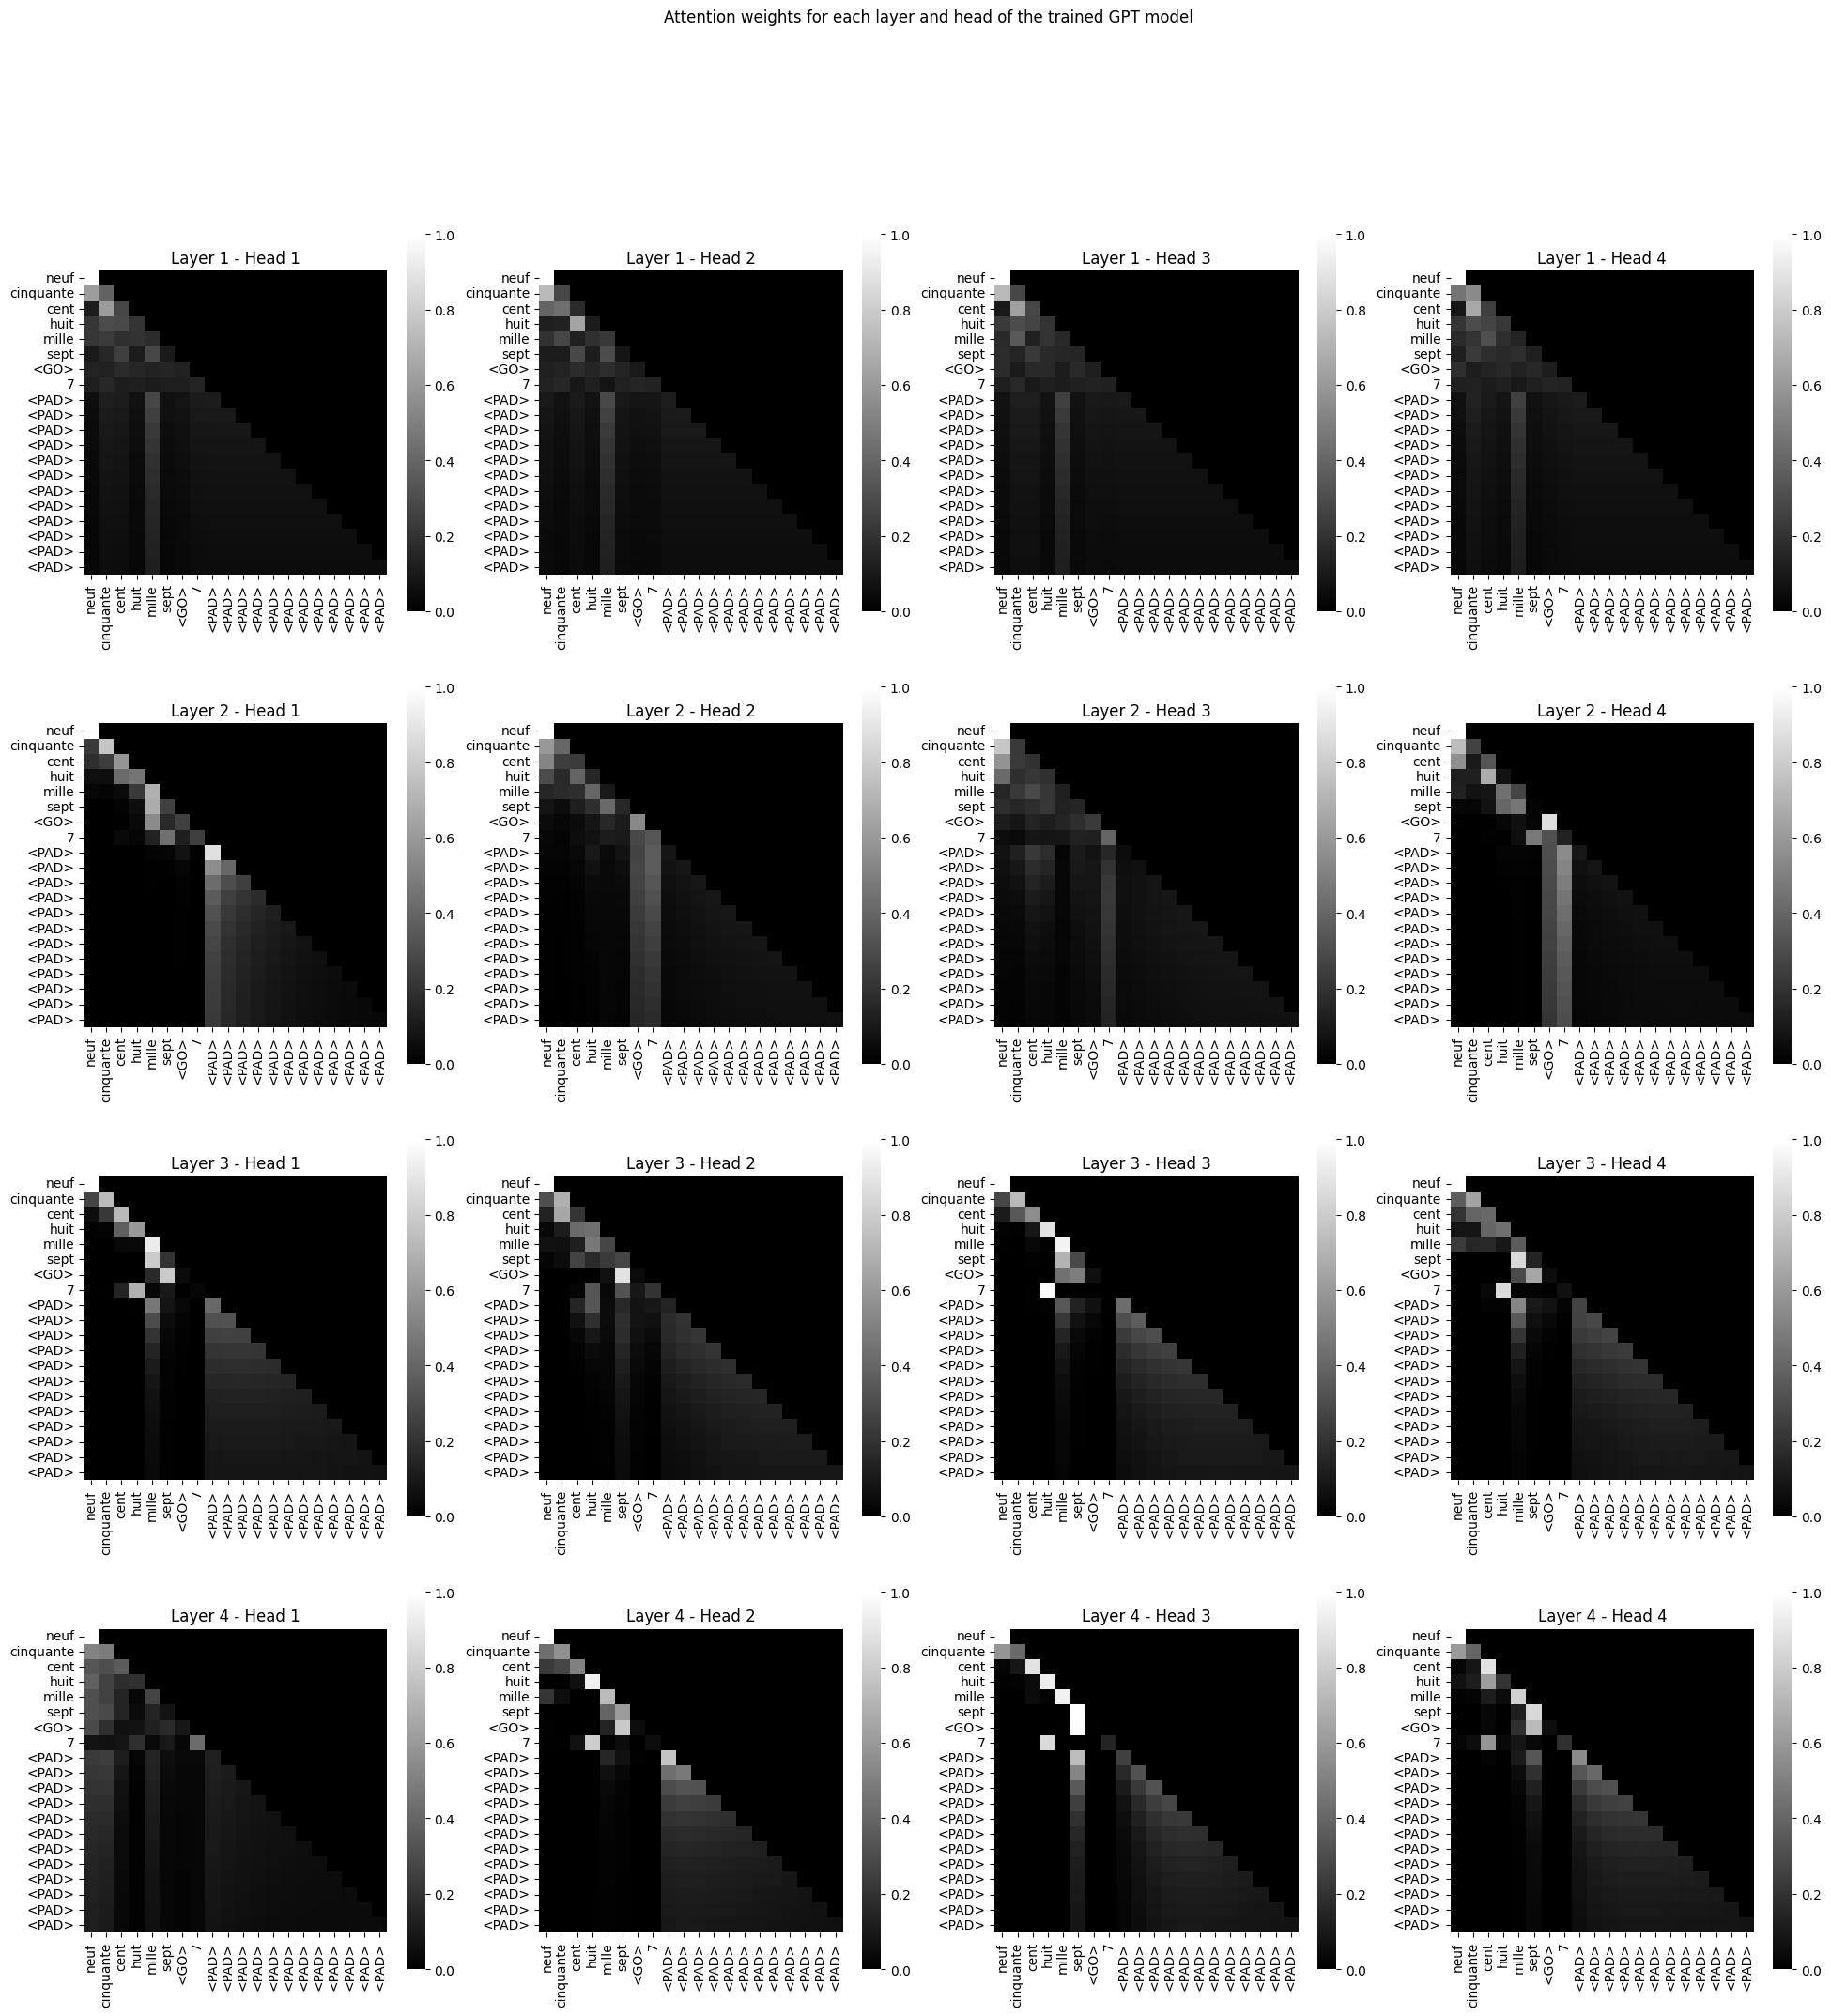

In [98]:
import seaborn as sns

n_layers = attention_map.shape[1]
n_heads = attention_map.shape[2]
tokens = [rev_vocab[t] for t in input_array[0, :]]

fig, ax = plt.subplots(nrows=n_layers, ncols=n_heads, figsize=(24, 24))
for layer_idx in range(n_layers):
    for head_idx in range(n_heads):
        sns.heatmap(
            attention_map[0, layer_idx, head_idx].cpu().numpy(),
            ax=ax[layer_idx, head_idx],
            xticklabels=tokens,
            yticklabels=tokens,
            square=True,
            cmap="gray",
        )
        ax[layer_idx, head_idx].set_title(
            f"Layer {layer_idx + 1} - Head {head_idx + 1}"
        )
_ = plt.suptitle("Attention weights for each layer and head of the trained GPT model")


How to read those maps:

- When looking at a row, we see the attention weight of the model giving importance to previous input tokens;
- Sometimes, they are intuitive to grasp, especially when reading the lines tokens after `<GO>` token but before the `<PAD>` tokens;
- Other lines (e.g. the lines for the `<PAD>` tokens in the input) are pretty meaning less.

### Questions

- What is the output shape of each transformer block in the forward pass?
    - Try to reason in your head first by reading the source code;
    - Check that your reasoning is correct by inserting;
    - Alternatively, use `summary(gpt_seq2seq, input_data=first_input_batch)` from the `torchinfo` package in a the notebook cell below.
- What is the meaning of each axis? How does the number of heads impacts those shape?
- How many trainable parameters in total?

### Exercises

In new notebook cells below:

- Build a new version of the training, validation and test sets and their data loaders without reversing the order of the source tokens in the input sequences;
- Train a new instance of the previous model classes (`RecurrentSeq2Seq` and `GPT`) on this new data:
    -  **WARNING** do not forget to create new Adam optimizer instances that update the parameters of the new models instead of updating the parameters of the previously trained models!
- Does the order of the source tokens impact the test-set performance of the gru-based seq2seq model?
- Does the order of the source tokens impact the test-set performance of the transformer-based seq2seq model?

In [99]:
# TODO: write your code here, do not edit the previous models and dataloader
# but feel free to reuse any existing class or function defined above, in
# particular the `vectorize_corpus` which accepts a `reverse_source=True/False`
# keyword argument.

In [100]:
# As always, feel free to insert as many new notebook cells as you want.

# Going Further (optional exercises)

We only scratched the surface of sequence-to-sequence systems. To go further, we recommend reading the initial [Sequence to Sequence paper](https://arxiv.org/abs/1409.3215) as well as later developments, in particular [Attention is all you need paper](https://arxiv.org/abs/1706.03762) that introduced the transformer architecture with self-attention layers.

Here are a few pointers on how to go further if you're interested in getting more practical experience with those models.

### Reverse translation: Numeric to French

- Build a model, with the same data but for the opposite task: translate from Numeric to French
- Use the same kind of architectures

### Check the importance of position embeddings for the transformer-based model

- Try to comment out the use of position embedding in the forward pass of the transformer and check the impact on sequence-level accuracy of the model.
- Why do you think this happens? Try to think what becomes permutation invariant or not but also how much accuracy you would get when trying to transcribe French sentences to number when the word order is randomly permuted.
- Do you think the performance degradation would be higher or lower when doing the same experiments for models trained on the Numeric to French task instead of the French to Numeric task?

### Impact of the model architecture on sample efficiency

- Generate a new version of the dataset by subsampling the original training data (e.g. 1000 examples).
- For the recurrent network model, try to add multiple, larger GRU layers and more dropout regularization.
- Similarly for the transformer based model, try to increase the number of layers, number of attention heads and embedding size to see the impact on the model performance, with smaller training sets.
- Quite counter intuitively, this might make it possible train a perfect translation model with a smaller amount of labeled samples. Try to train a seq2seq model with only 4000 training sequences or even fewer without overfitting.

### Separated Encoder-Decoder

We may want to build a model with a separated encoder and decoder, and expect to improve the performance by using a more flexible architecture.

The encoder would read the source sequence to build one embedding vector or a set of per-source-token embedding vectors in one forward pass.

The decoder will then iteratively predict one token at a time. The first layer of the decoder is feed both the output and the encoder and the embedding of the previously decoded tokens.

There is no need to "causal" constraints in the encoder: if using a transformer for the encoder, then the token embedding of a given layer can be computed from all the embeddings of the previous layer (past and future).

The encoder-decoder pair can still be trained end-to-end via teacher forcing, meaning that it's important for the decoder to use a "causal" architecture (uniderectional GRU/LSTM or causal transformer) to make sure that token decoding cannot access information from the "future".

Also, when using transformers,  It's important use positional embeddings both for the encoder and the decoder (for transformers). It's important use positional embeddings both for the encoder and the decoder (for transformers).

Try to implement a Encoder-Decoder Seq2Seq architecture an apply it to the French numbers dataset. It's possible to either do it using a recurrent-network based architecture or a transformer based architecture as shown on this diagram:

<img src="https://m2dsupsdlclass.github.io/lectures-labs/slides/07_deep_nlp_2/images/transformer.png" height="500px" />

When training and using such an architecture, the source tokens are passed separately instead of being concatenated to the target tokens in the input with the `<GO>` special token. The encoder-decoder join model has therefore two inputs: the source tokens and the previously predicted tokens. When preparing the expected outputs for teacher forcing training, one should also ensure to pass shifted tokens for the target sequence, without source length extra padding as we did above for the decoder only architecture.

### Beam search decoding

The naive greedy decoding strategy we used does not necessarily select the most likely sequence overall. Using a beam-search algorithm might lead to better results for instance, however it is significantly more complex to implement correctly.